# 01-09 Optimizers: How to optimize a portfolio

In [1]:
# error function will be sharpe ratio * -1
# ranges, limit allocation values from [0,1]
# constraints: properties of X that must be true, i.e. sum of allocation values must add up to 1.0


# http://quantsoftware.gatech.edu/Machine_Learning_for_Trading_Course

# http://quantsoftware.gatech.edu/MC1-Project-2

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as spo
from DataHelper import DataHelper
import collections


In [3]:
def assess_portfolio(start_date='2010-01-01', end_date='2010-12-31', symbol_allocs = {}, start_val=1000000, rfr=0.0, sf=252.0):
    """finds the optimal alllocations for a given set of stocks using Sharpe ratio as bench mark
    
    Parameters
    ----------
    start_date: string
    end_date: string
    symbols_allocs: dictionary/OrderedDict of symbols and their allocations
    start_val: number
    
    Returns
    -------
    dictionary:
        cum_ret:
        avg_period_ret: daily by default (sf=252)
        std_dev_period_ret: daily by default (sf=252)
        sharpe_ratio:
        ending_value:
    
    """
    if(sum(symbol_allocs.values()) != 1.0):
        print("ERROR: allocations must sum to 1.0")
        return {}
    
    symbols = list(symbol_allocs.keys())
    priceHistory = DataHelper.GetPriceHistory(symbols, start_date, end_date)
    symbols = list(symbol_allocs.keys())
    data = priceHistory[symbols]
        
    # calculate cum return and port_val
    normed = DataHelper.normalize_data(data)
    alloced = normed * list(symbol_allocs.values())
    pos_vals = alloced * start_val
    port_val = pos_vals.sum(axis=1)
    cum_ret = (port_val[-1] / port_val[0]) - 1
    
    # daily returns
    daily_ret = DataHelper.compute_daily_returns(port_val)[1:,]
    
    # sharpe ratio
    std = daily_ret.std()
    sharpe_ratio = ((daily_ret.mean() - rfr) / std) * (sf **(1/2.0))
    
    return {"cum_ret": cum_ret, "daily_ret": daily_ret.mean(), "std_ret": std, "sharpe_ratio": sharpe_ratio}

In [3]:
# test assess_portfolio
od = collections.OrderedDict([('GOOG', 0.2), ('AAPL', 0.3), ('GLD', 0.4), ('XOM', 0.1)])
assess_portfolio(symbol_allocs=od, start_date='2010-06-01')



{'cum_ret': 0.20511393879215278,
 'daily_ret': 0.0012958692436644658,
 'sharpe_ratio': 2.2125976667229317,
 'std_ret': 0.009297346197073994}

In [81]:
# optimize portfolio

def get_stats(normed, weights, rfr=0.0, sf=252.0):
    alloced = normed * weights
    pos_vals = alloced * 1
    port_val = pos_vals.sum(axis=1)
    cum_ret = (port_val[-1] / port_val[0]) - 1
    daily_ret = DataHelper.compute_daily_returns(port_val)[1:,]
    mean = daily_ret.mean()
    std = daily_ret.std()
    sharpe_ratio = ((mean - rfr) / std) * (sf **(1/2.0)) 
    stats = {"cum_ret": cum_ret, "daily_ret": mean, "std_ret": std, "sharpe_ratio": sharpe_ratio}
    return stats, port_val
    

def min_func_sharpe(weights, normed, rfr=0.0, sf=252.0):
    alloced = normed * weights
    pos_vals = alloced * 1
    port_val = pos_vals.sum(axis=1)
    daily_ret = DataHelper.compute_daily_returns(port_val)[1:,]
    std = daily_ret.std()
    sharpe_ratio = ((daily_ret.mean() - rfr) / std) * (sf **(1/2.0))
    return -sharpe_ratio


def optimize_portfolio(start_date, end_date, symbols, gen_plot=False):
    noa = len(symbols) # number of assets
    priceHistory = DataHelper.GetPriceHistory(symbols, start_date, end_date, False)
    normed = DataHelper.normalize_data(priceHistory)
    
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bnds = tuple((0,1) for x in range(noa))
    
    initial_guess = noa * [1. / noa]
    
    opts = spo.minimize(min_func_sharpe, initial_guess, args=(normed,), method='SLSQP', bounds=bnds, constraints=cons )
    
    ret,pval = get_stats(normed, opts.x)
    ret["optimal_allocs"] = opts.x
    ret["SPY_stats"] = assess_portfolio(start_date, end_date, symbol_allocs = {'SPY': 1.0})
    
    if(gen_plot):
        
        spyHistory = DataHelper.GetPriceHistory(['SPY'], start_date, end_date)
        spyNorm = DataHelper.normalize_data(spyHistory)
        
        ax = spyNorm.plot(label="SPY", figsize=(20,10))
        plt.plot(pval, label='Portfolio')
        plt.legend(loc=0)
        
        plt.show()
    
    return ret
    
    

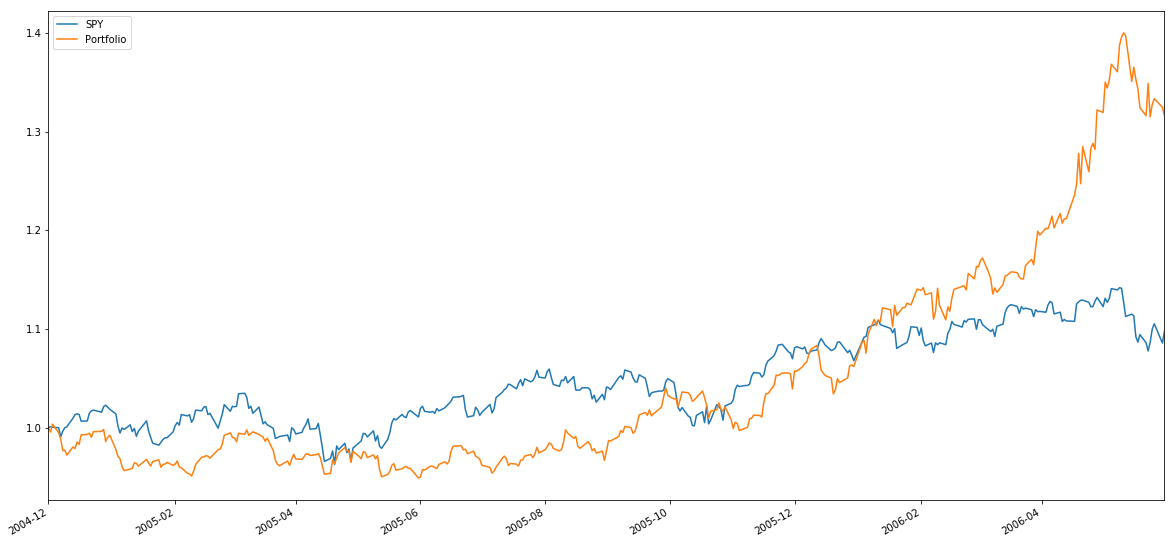

{'SPY_stats': {'cum_ret': 0.097746561311091495,
  'daily_ret': 0.0002687951509921049,
  'sharpe_ratio': 0.661967874516653,
  'std_ret': 0.006445918152730014},
 'cum_ret': 0.31597380772409589,
 'daily_ret': 0.0007621702426021249,
 'optimal_allocs': array([ 0.        ,  0.07528198,  0.585249  ,  0.33946902]),
 'sharpe_ratio': 1.5178365769105553,
 'std_ret': 0.007971264954189414}

In [85]:
start_date = '2004-12-01'
end_date = '2006-05-31'
symbols = ['YHOO', 'XOM', 'GLD', 'HNZ']
    
stats = optimize_portfolio(start_date, end_date, symbols, True)
stats